In [3]:
%run setup/GpuOptions.ipynb

Enabling memory growth on PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [26]:
import os
import sys

sys.path.append('..')

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, optimizers, losses
import common.model as m
from common.dataset import Dataset

dataset = Dataset(
    '../dataset/dataset-2022-10-19T22-51-08',
    batch_size=8,
    image_size=(1920, 1080))
augmentation = [
    layers.RandomTranslation(0.05, 0.05, fill_mode='nearest'),
    layers.RandomBrightness(0.025),
    # Cropping2D parameter are how much to take off of top, bottom, 
    # left and right, not a rectangle of the cropped image
    layers.Cropping2D(cropping=((160, 350), (580, 450))),
]
classes = dataset.training.class_names
data, _ = next(iter(dataset.training))
shape = data[0].shape
inputs = tf.keras.Input(shape=shape)

outputs = m.chained(
    # Augmentations
    *augmentation,
    # Entry Flow
    layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    m.expand(
        flow=lambda previous_activation, size: layers.add([
            m.chained(
                m.duplicate(
                    layers=lambda: [
                        layers.Activation('relu'),
                        layers.SeparableConv2D(filters=size, kernel_size=3, padding='same'),
                        layers.BatchNormalization(),
                    ],
                    count=2
                ),
                layers.MaxPooling2D(pool_size=3, strides=2, padding='same'),
            )(previous_activation),
            layers.Conv2D(filters=size, kernel_size=1, strides=2, padding='same')(previous_activation),
        ]),
        values=[128, 256, 728],
    ),

    # Middle Flow
    m.expand(
        flow=lambda previous_activation, _: layers.add([
            m.duplicate(
                layers=lambda: [
                    layers.Activation('relu'),
                    layers.SeparableConv2D(filters=728, kernel_size=3, padding='same'),
                    layers.BatchNormalization(),
                ],
                count=3,
            )(previous_activation),
            previous_activation,
        ]),
        values=[0] * 8
    ),

    # Exit Flow
    lambda previous_activation: layers.add([
        m.chained(
            layers.Activation('relu'),
            layers.SeparableConv2D(filters=728, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.SeparableConv2D(filters=1024, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=3, strides=2, padding='same'),
        )(previous_activation),
        layers.Conv2D(filters=1024, kernel_size=1, strides=2, padding='same')(previous_activation),
    ]),
    layers.Activation('relu'),
    layers.SeparableConv2D(filters=728, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.SeparableConv2D(filters=1024, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(classes), activation='linear'),
    layers.Dropout(0.2),
)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.build(input_shape=(None, *shape))
model.compile(
    optimizer=optimizers.Adadelta(
        learning_rate=optimizers.schedules.CosineDecayRestarts(
            1.0,
            # Decay over 5 epochs and then restart 
            dataset.training.cardinality().numpy() * 5)),
    loss=losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.03),
    metrics=['accuracy'],
)
if os.path.exists('isthemountainout.best.h5'):
    print('loading weights from best')
    model.load_weights('isthemountainout.best.h5')
elif os.path.exists('isthemountainout.h5'):
    print('loading weights from saved model')
    model.load_weights('isthemountainout.h5')
print(model.summary())

Found 3106 files belonging to 4 classes.
Using 2485 files for training.
Found 3106 files belonging to 4 classes.
Using 621 files for validation.
loading weights from best
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1920, 1080,  0           []                               
                                 3)]                                                              
                                                                                                  
 random_translation_2 (RandomTr  (None, 1920, 1080,   0          ['input_3[0][0]']                
 anslation)                     3)                                                                
                                                                                                  
 random_brightness_2

In [3]:
from datetime import datetime

model.fit(
    dataset.training,
    epochs=700,
    verbose=True,
    validation_data=dataset.validation,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'isthemountainout.best.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=True),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=20,
            restore_best_weights=True,
            verbose=True),
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join('tensor-logs', 'fit', datetime.now().strftime('%Y%m%d%H%M%S')),
            update_freq=50,
            write_images=True,
            write_graph=True,
            embeddings_freq=10),
    ])

Epoch 1/700
311/311 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.8382
Epoch 1: val_loss improved from inf to 0.48249, saving model to isthemountainout.best.h5
311/311 [==============================] - 155s 454ms/step - loss: 0.4856 - accuracy: 0.8382 - val_loss: 0.4825 - val_accuracy: 0.8760
Epoch 2/700
311/311 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.8394
Epoch 2: val_loss improved from 0.48249 to 0.41030, saving model to isthemountainout.best.h5
311/311 [==============================] - 139s 446ms/step - loss: 0.4869 - accuracy: 0.8394 - val_loss: 0.4103 - val_accuracy: 0.9082
Epoch 3/700
311/311 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.8439
Epoch 3: val_loss improved from 0.41030 to 0.31749, saving model to isthemountainout.best.h5
311/311 [==============================] - 139s 445ms/step - loss: 0.4633 - accuracy: 0.8439 - val_loss: 0.3175 - val_accuracy: 0.9114
Epoch 4/700
311/311 [========

KeyboardInterrupt: 

loading model with best weights
Found 3106 files belonging to 4 classes.
Using 2485 files for training.
Found 3106 files belonging to 4 classes.
Using 621 files for validation.
78/78 [==============================] - 12s 138ms/step


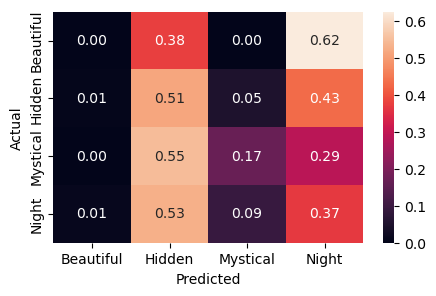

In [27]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

print('loading model with best weights')
model.load_weights('isthemountainout.best.h5')

validations = dataset.validation
predictions = tf.math.argmax(
  tf.nn.softmax(
    model.predict(validations)), axis=1)
labels = tf.argmax(tf.concat([label for _, label in iter(validations)], axis=0), axis=1)
cm = confusion_matrix(labels, predictions, labels=list(range(len(dataset.validation.class_names))))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(
  cmn,
  annot=True,
  fmt='.2f',
  xticklabels=dataset.validation.class_names,
  yticklabels=dataset.validation.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)